In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from tqdm import tqdm

import timeit
import time
import math

# ./indexer
from indexer import AppendIndexer
import ALS

# Annoy
from annoy import AnnoyIndex

#SKLearn 
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import average_precision_score
from sklearn.metrics import pairwise_distances

# scipy
from scipy.spatial import distance
from scipy.sparse import lil_matrix

## Utils

In [28]:
def calc_nDCG(annoy_indices, knn_indices, k, discount = 3):
    aa = []
    for i in range(len(annoy_indices)):
        b = []
        for j in annoy_indices[i][1:]:
            if j in knn_indices[i][:k]:
                b.append(1)
            else:
                b.append(0)
        aa.append(b)
    res = []
    for a in aa:
        acc = 0
        for i in range(len(a)):
            acc += a[i]/math.log(i+7, 7)
        if not len(a):
            res.append(0)
        else:
            res.append(acc/len(a))
    return np.array(res).mean()

def calc_acc(annoy_indices, knn_indices, k):
    aa = []
    for i in range(len(annoy_indices)):
        b = []
        for j in annoy_indices[i][1:]:
            if j in knn_indices[i][:k]:
                b.append(1)
            else:
                b.append(0)
        aa.append(b)
    res2 = []
    for a in aa:
        acc2 = 0
        for i in range(len(a)):
            acc2 += a[i]
        if not len(a):
            res2.append(0)
        else:
            res2.append(acc2/len(a))
    return np.array(res2).mean()

In [29]:
entekhab_content = pd.read_csv('./pages_entekhab.csv')
entekhab_content.head(20)

,id,created,content_vector,title,cleaned_url,website_id,included,is_amp,has_image_meta,has_title_meta,page_id,subdomain_id,title_vector,image_id,cats
0,761039,2020-08-09 03:40:44.820172+04:30,"{0.264251947402954,-0.644542038440704,-0.18412...",یادداشت‌های علم، شنبه ۲۴ مرداد ۱۳۴۹: ایادی ما ...,entekhab.ir/fa/news/495749/%DB%8C%D8%A7%D8%AF%...,2,t,f,f,t,28054354,73,"{3.626948595047,0.779965162277222,0.8395900726...",602.0,{23}
1,2754181,2020-09-26 03:50:01.442172+03:30,"{0.273704349994659,-0.830473184585571,-0.28864...",ايران همچنان همان امپراتوری پارس است / عربستا...,entekhab.ir/fa/news/266708/%D8%A7%D9%8A%D8%B1%...,2,t,f,f,t,37476083,73,"{1.13415098190308,-1.20623469352722,-0.6013424...",621.0,{15}
2,4286495,2020-10-03 10:35:21.85205+03:30,"{0.853439688682556,-0.564931094646454,-0.37323...",همه آنچه برای ترامپ در شب گذشته رخ داد؛ از تنگ...,entekhab.ir/fa/news/577730/%D9%87%D9%85%D9%87-...,2,t,f,t,t,38017087,73,"{2.13742733001709,-1.12283325195312,-0.3791791...",1530910.0,{15}
3,4875542,2020-10-10 09:40:15.864975+03:30,"{1.15192973613739,-0.138078510761261,0.6881629...",پیکر ۲ جانباخته ریزش ساختمان در در خیابان ابوذ...,entekhab.ir/fa/news/578944/%D9%BE%DB%8C%DA%A9%...,2,t,f,t,t,38559541,73,"{0.230344951152802,0.131352335214615,0.9686161...",1758716.0,{21}
4,536136,2020-08-09 03:29:13.257136+04:30,"{0.704237043857574,-1.47816872596741,0.4682139...",7تن گوشت چرخ کرده با سنگدون مرغ یخ زده و چربی ...,entekhab.ir/fa/news/434541/7%D8%AA%D9%86-%DA%A...,2,t,f,t,t,29837398,73,"{3.626948595047,0.779965162277222,0.8395900726...",750.0,{22}
5,926557,2020-08-09 03:48:27.715412+04:30,"{-0.272317439317703,0.354126185178757,0.105726...",ویدیو / دری نجف آبادی: ممکن است FATF از دستور ...,entekhab.ir/fa/news/553636/%D9%88%DB%8C%D8%AF%...,2,t,f,f,t,27251139,73,"{3.626948595047,0.779965162277222,0.8395900726...",NaN,{23}
6,2679316,2020-09-19 21:33:51.475395+04:30,"{0.808205783367157,-0.969625532627106,-0.40755...",تا زمان برگزاری انتخابات آمریکا و بیان صریح مو...,entekhab.ir/fa/news/575411/%D8%AA%D8%A7-%D8%B2...,2,t,f,t,t,36975475,73,"{1.24864614009857,-1.19327878952026,-0.5599737...",1324.0,{15}
7,4286727,2020-10-03 10:45:24.947041+03:30,"{0.853987216949463,-0.202528178691864,-0.49360...",رئیس پلیس تهران: ارسال اشتباهی پیامک‌های حجاب ...,entekhab.ir/fa/news/577736/%D8%B1%D8%A6%DB%8C%...,2,t,f,t,t,38018045,73,"{1.85497891902924,0.154068395495415,-0.8957029...",1531042.0,{15}
8,464068,2020-08-09 03:25:58.532063+04:30,"{-1.08582651615143,0.0488543212413788,0.038908...",ویدیو / توضیحات رئیس دفتر رئیس جمهور درمورد سن...,entekhab.ir/fa/news/560545/%D9%88%DB%8C%D8%AF%...,2,t,f,f,t,30691160,73,"{3.626948595047,0.779965162277222,0.8395900726...",NaN,{23}
9,502039,2020-08-09 03:27:52.377476+04:30,"{0.598500967025757,-0.519518435001373,-0.30455...",دیگر در تهران تخت خالی برای بستری بیمار کرونای...,entekhab.ir/fa/news/559856/%D8%AF%DB%8C%DA%AF%...,2,t,f,t,t,30236589,73,"{3.626948595047,0.779965162277222,0.8395900726...",1720.0,{-1}


In [30]:
entekhab_content.shape

(65246, 15)

In [31]:
entekhab_content = entekhab_content[entekhab_content.included == 't']
entekhab_content.shape

(65243, 15)

## CF

In [32]:
class ViewMatrix:
    def __init__(self, path):
        self.path = path
        self.original = True
        self.item_indexer = AppendIndexer.load('./entekhab.ir/cf/alisssss/item_indexer.indexer')
        self.user_indexer = AppendIndexer.load('./entekhab.ir/cf/alisssss/user_indexer.indexer')
        
    def load_matrix(path):
        
        matrix = ViewMatrix(path)

        try:
            matrix.view_matrix = ViewMatrix \
                .load_sparse_lil(path)
        except:
            print('Error: loading', path)

        return matrix

    def load_sparse_lil(filename):
        loader = np.load(filename, allow_pickle=True)
        result = lil_matrix(tuple(loader["shape"]), dtype=str(loader["dtype"]))
        result.data = loader["data"]
        result.rows = loader["rows"]
        return result
    
    def make_dense(self, user_min_view, item_min_view):
        self.original = False
        while True:
            removed_rows_cnt = self.trim_users_with_few_views(user_min_view)
            removed_columns_cnt = self.trim_columns_with_few_views(item_min_view)
            if not removed_columns_cnt and not removed_rows_cnt:
                break

    def trim_users_with_few_views(self, user_min_view):
        removing_row_indices = list(np.where(self.view_matrix.getnnz(1) < user_min_view)[0])
        print('Number of users which should be deleted:', len(removing_row_indices))
        self.trim_user_indices(to_remove_indices=removing_row_indices)
        return len(removing_row_indices)

    def trim_columns_with_few_views(self, column_min_view):
        removing_column_indices = list(np.where(self.view_matrix.getnnz(0) < column_min_view)[0])
        print('Number products which should be deleted:', len(removing_column_indices))
        self.trim_column_indices(to_remove_indices=removing_column_indices)
        return len(removing_column_indices)
    
    def trim_user_indices(self, to_remove_indices):
        self.user_indexer.remove_indexes(to_remove_indices)
        self.view_matrix = ViewMatrix.delete_row_lil(self.view_matrix, to_remove_indices)
    
    def trim_column_indices(self, to_remove_indices):
        self.item_indexer.remove_indexes(to_remove_indices)
        self.view_matrix = ViewMatrix.delete_column_lil(self.view_matrix, to_remove_indices)
    
    def delete_column_lil(mat: lil_matrix, *i) -> lil_matrix:
        mat = mat.transpose()
        mat = ViewMatrix.delete_row_lil(mat, *i)
        return mat.transpose()
    
    def delete_row_lil(mat: lil_matrix, *i) -> lil_matrix:
        if not isinstance(mat, lil_matrix):
            raise ValueError("works only for LIL format -- use .tolil() first")
        mat = mat.copy()
        mat.rows = np.delete(mat.rows, i)
        mat.data = np.delete(mat.data, i)
        mat._shape = (mat.rows.shape[0], mat._shape[1])
        return mat
    def to_csr(self):
        train_data = self.view_matrix.astype(np.float64)
        train_data = train_data.tocoo()
        train_data.data = np.log10(train_data.data) + 1
        train_data = train_data.tocsr()
        return train_data

### Training CF

In [33]:
def CFTrain(path: str, _alpha = 15, factors = 20):
    now = time.time()
    matrix = ViewMatrix.load_matrix(path)
    print('View matrix loaded in', time.time() - now, 'seconds.')

    now = time.time()
    sparce_matrix = matrix.to_csr()
    matrix.make_dense(user_min_view = 2, 
                      item_min_view = 2)
    print('matrix has been made dense in', time.time() - now, 'seconds.')

    als_model = ALS.Als(num_factors = factors,
                        iterations = 15,
                        num_threads = 15,
                        alpha = _alpha)

    implicit_matrix = matrix.to_csr()

    print()
    now = time.time()
    als_model.fit(implicit_matrix)
    print('ALS model is fitted in', time.time() - now, 'seconds.')
    
    print('Saving Data ...')
    matrix.item_indexer.dump('./ali_item_indexer_factorized.indexer')
    matrix.user_indexer.dump('./ali_user_indexer_factorized.indexer')
    np.save('./ali_items_vectors.npy', als_model.item_vectors)
    np.save('./ali_users_vectors.npy', als_model.user_vectors)
    
    return sparce_matrix, implicit_matrix, als_model.item_vectors, als_model.user_vectors

creating item_vectors

In [8]:
sparce_matrix, implicit_matrix, item_vectors, user_vectors = \
CFTrain('./entekhab.ir/cf/alisssss/lil_matrix.npz', factors = 20)

View matrix loaded in 10.40421199798584 seconds.
Number of users which should be deleted: 1784866
Number products which should be deleted: 26556
Number of users which should be deleted: 2255
Number products which should be deleted: 155
Number of users which should be deleted: 77
Number products which should be deleted: 4
Number of users which should be deleted: 2
Number products which should be deleted: 0
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 37.77670502662659 seconds.

ALS model is fitted in 29.936022996902466 seconds.
Saving Data ...


In [9]:
implicit_matrix.shape

(309950, 6051)

## Building KNN model

### SK-Learn

In [38]:
def sk_KNN(item_vectors, number_of_neighbours = 10):
    start = time.time()

    knn_distances_brute = []
    knn_indices_brute = []

    nbrs = NearestNeighbors(n_neighbors=number_of_neighbours, algorithm='ball_tree'). \
        fit(item_vectors)

    knn_distances_brute, knn_indices_brute = nbrs.kneighbors(item_vectors)

    end = time.time()
    print('ball_tree time:', end-start)
    
    return knn_distances_brute, knn_indices_brute

### Annoy

In [40]:
def get_annoy_results(pages_vector, number_of_trees = 170, number_of_neighbours = 10):
    
    start = time.time()
    annoy_model = annoy_model = AnnoyIndex(pages_vector.shape[1], 'angular')
    
    for index, vector in enumerate(pages_vector):
        annoy_model.add_item(index, vector)
    
    annoy_model.build(number_of_trees)
    
    annoy_indices = []
    annoy_distances = []

    for i in pages_vector:
        indices, distances = annoy_model. \
            get_nns_by_vector(i, number_of_neighbours, include_distances=True)
        annoy_indices.append(indices)
        annoy_distances.append(distances)
    
    duration = time.time() - start
    print('annoy time:', duration)
    return annoy_indices, annoy_distances, duration

## Accuracy and Diversity measures

### Calculating Mean Absolute Error

In [13]:
now = time.time()
aproximated_matrix = np.matmul(user_vectors, np.transpose(item_vectors))
time.time() - now

23.206481218338013

In [68]:
start = time.time()
implicit_matrix = implicit_matrix.toarray()
absolute_error = abs(aproximated_matrix - implicit_matrix)
time.time() - start

243.35003805160522

In [69]:
start = time.time()
MAE = absolute_error.mean()
time.time() - start

77.50116991996765

In [70]:
MAE

0.011707617631696317

### Accuracy measure

In [41]:
annoy_indices, annoy_distances, duration = get_annoy_results(item_vectors)

annoy time: 2.4457099437713623


In [42]:
knn_distances_brute, knn_indices_brute = sk_KNN(item_vectors)

ball_tree time: 0.907707929611206


In [15]:
accs = []
times = []
for k in range(4,30):
    annoy_indices, annoy_distances, duration = \
    get_annoy_results(item_vectors, number_of_neighbours = k)
    times.append(duration)
    accs.append(calc_acc(annoy_indices, knn_indices_brute, k))

annoy time: 1.8875911235809326
annoy time: 2.064847946166992
annoy time: 2.1709229946136475
annoy time: 2.436220169067383
annoy time: 2.5594890117645264
annoy time: 2.5522642135620117
annoy time: 2.9029910564422607
annoy time: 2.8531131744384766
annoy time: 3.0907740592956543
annoy time: 3.239093065261841
annoy time: 3.2458598613739014
annoy time: 3.4362070560455322
annoy time: 3.4143049716949463
annoy time: 3.1991989612579346
annoy time: 3.641252040863037
annoy time: 3.4402010440826416
annoy time: 3.463758945465088
annoy time: 3.467146873474121
annoy time: 4.107266902923584
annoy time: 4.303592920303345
annoy time: 4.217787265777588
annoy time: 3.944735050201416
annoy time: 4.375971078872681
annoy time: 4.522526264190674
annoy time: 4.097538948059082
annoy time: 4.172906875610352


Text(0, 0.5, 'Accuracy')

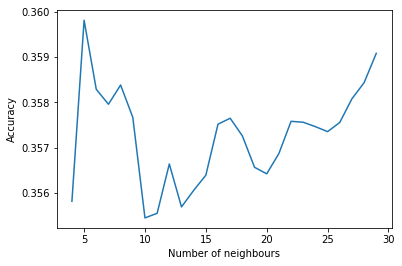

In [16]:
plt.plot(range(4, 30), accs)
plt.xlabel('Number of neighbours')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Time')

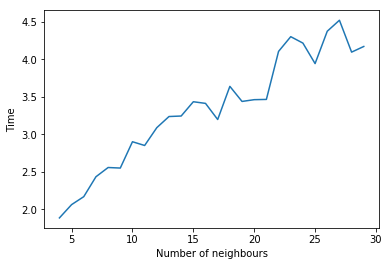

In [117]:
plt.plot(range(4, 30), times)
plt.xlabel('Number of neighbours')
plt.ylabel('Time')

In [ ]:
_times = []
_accs = []
_nDCGs = []

for i in [5, 10, 15, 30, 50, 60, 100, 150, 200, 250]:
    start = time.time()
    annoy_indices, annoy_distances, duration = \
    get_annoy_results(item_vectors, number_of_neighbours = 10, number_of_trees = i)
    _nDCGs.append(calc_nDCG(annoy_indices, indices, 10))
    _accs.append(calc_acc(annoy_indices, indices, 10))
    _times.append(time.time() - start)
    print(_nDCGs[-1], _accs[-1], _times[-1])

### Precision and recall at k

Precision@k = # recommended @k and relevant / # recommended (k) <br>
Recall@k    = # recommended @k and relevant / # relevant ion top k

In [10]:
implicit_matrix = implicit_matrix.toarray()

In [11]:
from tqdm import tqdm
idk = []
for i in tqdm(range(len(implicit_matrix))):
    temp = []
    for j in range(len(implicit_matrix[i])):
        if implicit_matrix[i][j] > 0:
            temp.append((implicit_matrix[i][j], j))
    idk.append(temp)

100%|██████████| 309950/309950 [21:52<00:00, 236.11it/s]


In [14]:
idk2 = []
for i in tqdm(range(len(aproximated_matrix))):
    temp = []
    for j in range(len(aproximated_matrix[i])):
        if aproximated_matrix[i][j] > 0.5:
            temp.append((aproximated_matrix[i][j], j))
    idk2.append(temp)

100%|██████████| 309950/309950 [18:35<00:00, 277.83it/s]


In [15]:
for i in tqdm(range(len(idk2))):
    idk2[i] = sorted(idk2[i], key=lambda x: x[1], reverse=True)

100%|██████████| 309950/309950 [00:02<00:00, 109920.83it/s]


In [20]:
def Precision_recall_at_k(idk2, idk, k):
    users_visited_indeces = \
    [[i[1] for i in idk[j]] for j in range(len(idk))]
    recommended_relevant = []
    relevants = []
    for i in range(len(idk2)):
        temp = 0
        if len(idk2[i]) >= k and len(users_visited_indeces[i]) >= k:
            for j in range(len(idk2[i][0:k])):
                if idk2[i][j][1] in users_visited_indeces[i]:
                    temp += 1
            recommended_relevant.append(temp)
            relevants.append(len(users_visited_indeces[i]))
    p = (np.array(recommended_relevant) / k).mean()
    r = []
    for i in zip(recommended_relevant, relevants):
        r.append(i[0]/i[1])
    r = np.array(r).mean()
    return p, r

Precision and recall at k

In [21]:
for k in range(1, 20):
    print('k =', k, Precision_recall_at_k(idk2, idk, k))

k = 1 (0.4843991913947089, 0.19579688397067174)
k = 2 (0.43686101354741597, 0.3298199375034461)
k = 3 (0.3443067013934359, 0.2381223673910578)
k = 4 (0.293185382685069, 0.18851703972475659)
k = 5 (0.2664661855118952, 0.16373089151841064)
k = 6 (0.2504320447598371, 0.14891967188973396)
k = 7 (0.24137652497718085, 0.14186289441354596)
k = 8 (0.23579764867416117, 0.1383974815713413)
k = 9 (0.23190402526668602, 0.13623040516546278)
k = 10 (0.22922149565404593, 0.13530742459465825)
k = 11 (0.2267427157039468, 0.13511678184481596)
k = 12 (0.22498753306448113, 0.1349868437331841)
k = 13 (0.22402379013700574, 0.13596648555641794)
k = 14 (0.22322840938528274, 0.1361866985649078)
k = 15 (0.22313728775692585, 0.1372402003565847)
k = 16 (0.22292600643028573, 0.13814572181485593)
k = 17 (0.22319128249661724, 0.1390321935576112)
k = 18 (0.22362635429857883, 0.14046450101109068)
k = 19 (0.22349083285300012, 0.14125817495751067)


## Calculating site trends list

In [100]:
visit = {}
for i in tqdm(range(len(implicit_matrix.T))):
    visit[i] = len([i for i in implicit_matrix.T[i] if i > 0])

100%|██████████| 6051/6051 [23:26<00:00,  4.30it/s]  


In [110]:
site_trend = {k: v for k, v in sorted(visit.items(), key=lambda item: item[1], reverse = True)}

## calculating coverage at k

In [149]:
def coverage(item_vectors, k):
    annoy_indices, annoy_distances, duration = \
    get_annoy_results(item_vectors, number_of_neighbours = k)
    for i in range(len(annoy_indices)):
        annoy_indices[i].pop(0)
    unique_recommendations = \
    len(np.unique(np.array(annoy_indices).reshape(len(annoy_indices) * (k - 1) )))
    return unique_recommendations / 32766

In [150]:
sparce_matrix.shape

(2097150, 32766)

In [151]:
for i in range(2, 20):
    print(coverage(item_vectors, i))

annoy time: 1.4707262516021729
0.11109076481718855
annoy time: 1.5604019165039062
0.1455472135750473
annoy time: 1.6639819145202637
0.16153940059818103
annoy time: 1.7697930335998535
0.1695965329915156
annoy time: 1.8955638408660889
0.17365561862906673
annoy time: 1.976144790649414
0.1762802905450772
annoy time: 2.1110599040985107
0.17838613196606237
annoy time: 2.2378549575805664
0.18021729841909295
annoy time: 2.2751922607421875
0.18128547885002746
annoy time: 2.618272066116333
0.1821705426356589
annoy time: 2.508976936340332
0.18262833424891656
annoy time: 2.5846078395843506
0.1830861258621742
annoy time: 2.9849469661712646
0.1833608008301288
annoy time: 2.855180025100708
0.18360495635719953
annoy time: 2.8943309783935547
0.18375755356161874
annoy time: 2.95340895652771
0.1838796313251541
annoy time: 3.051942825317383
0.1839406702069218
annoy time: 3.1495020389556885
0.18400170908868949


## Diversity

In [6]:
from sklearn.metrics.pairwise import cosine_similarity
def my_cosine_similarity(item1, item2):
    return cosine_similarity([item1, item2])[0][1]

In [152]:
item_indexer = \
AppendIndexer.load('./ali_item_indexer_factorized.indexer')

In [153]:
annoy_indices, annoy_distances, duration = get_annoy_results(item_vectors)

annoy time: 4.211301803588867


In [154]:
items = []
nulls = []
for i in item_indexer.get_items():
    temp = {}
    try:
        item_index = item_indexer.get(i)
        c_vec = np.array(entekhab_content[entekhab_content['id'] == int(i)].content_vector)[0]
        temp['content_vec'] = np.array([float(x) for x in str(c_vec)[1:-1].split(',')])
        temp['id'] = i
        temp['index'] = item_index
        temp['recommendations'] = annoy_indices[item_index]
        items.append(temp)
    except:
        nulls.append(item_index)

5879

In [12]:
item_content_map = {}
for i in items:
    item_content_map[i['index']] = i['content_vec']

In [148]:
entekhab_content[entekhab_content['id'] == int(item_indexer.reverse_get(42))]

,id,created,content_vector,title,cleaned_url,website_id,included,is_amp,has_image_meta,has_title_meta,page_id,subdomain_id,title_vector,image_id,cats
35289,6191581,2020-10-16 16:00:02.728632+03:30,"{1.37319898605347,-0.337699979543686,-0.527072...",مصباحی مقدم: آمریکا، رژیم صهیونیستی و عربستان ...,entekhab.ir/fa/news/580032/%D9%85%D8%B5%D8%A8%...,2,t,f,t,t,39360276,73,"{1.77412080764771,-1.28127646446228,-0.0060007...",2302131.0,"{11,15}"


### Context similarity w.r.t Approximated KNN rank using CF

In [25]:
similarities = []
for i in items:
    temp = []
    for j in i['recommendations']:
        try:
            temp.append(my_cosine_similarity(i['content_vec'], item_content_map[j]))
        except:
            continue
    similarities.append(temp)

In [26]:
similarities = np.array(similarities)

In [27]:
rank_similarity = []
for i in range(30):
    temp = []
    for j in similarities:
        if len(j) > i:
            temp.append(j[i])
    rank_similarity.append(np.array(temp))

rank 0


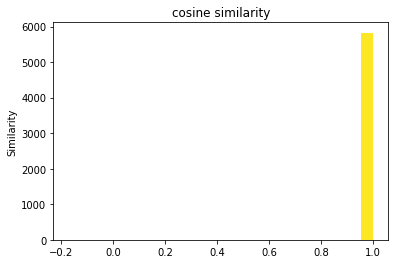

rank 2


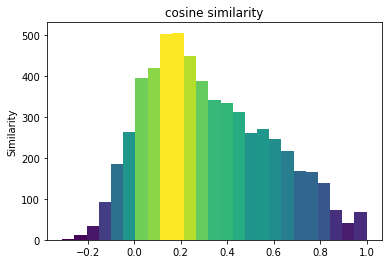

rank 4


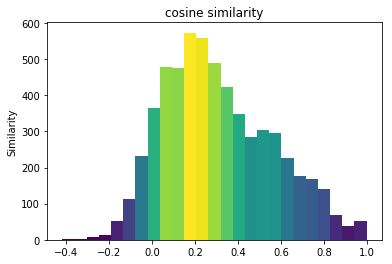

rank 6


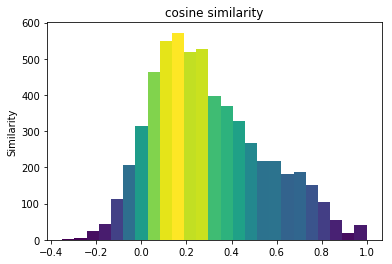

rank 8


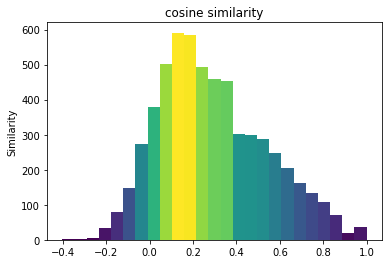

rank 10


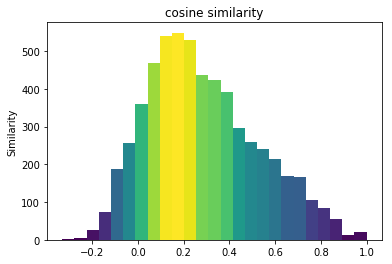

rank 12


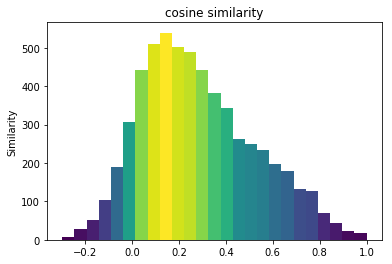

rank 14


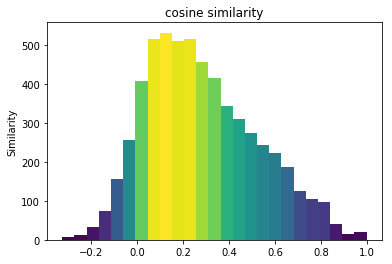

rank 16


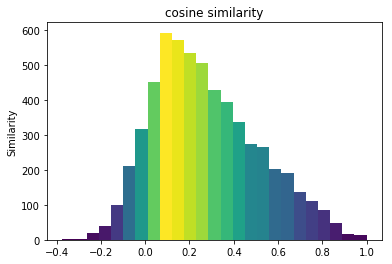

rank 18


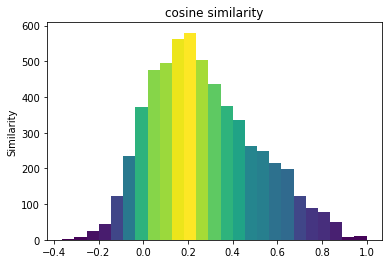

rank 20


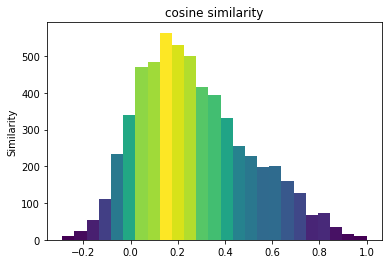

rank 22


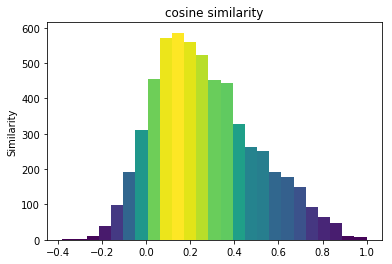

rank 24


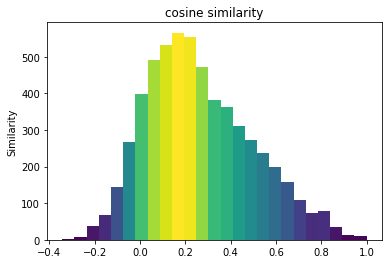

rank 26


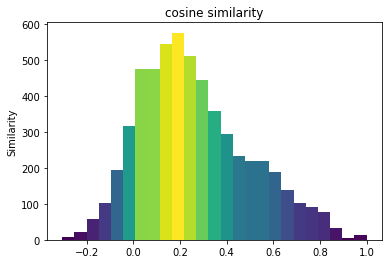

rank 28


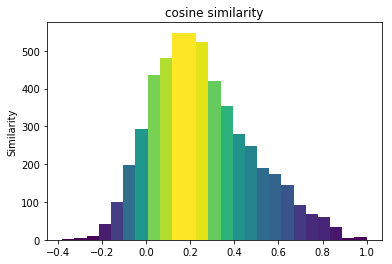

In [29]:
for i in range(0,30, 2):
    print('rank', i)
    n_bins = [25]
    for n_bin in n_bins:
        N, bins, patches = plt.hist(rank_similarity[i], bins=n_bin)
        fracs = N / N.max()
        plt.title('cosine similarity')
        plt.ylabel('Similarity')
        norm = colors.Normalize(fracs.min(), fracs.max())
        for thisfrac, thispatch in zip(fracs, patches):
            color = plt.cm.viridis(norm(thisfrac))
            thispatch.set_facecolor(color)
        plt.show()
        

In [197]:
similarities = []
for i in items:
    temp = []
    for j in i['recommendations']:
        try:
            temp.append(distance.cosine(i['content_vec'], item_content_map[j]))
        except:
            continue
    similarities.append(temp)

In [199]:
similarities = np.array(similarities)

In [203]:
rank_similarity = []
for i in range(30):
    temp = []
    for j in similarities:
        if len(j) > i:
            temp.append(j[i])
    rank_similarity.append(np.array(temp))

0.008539624502582778 0.007027227351839991
0.6259168286966322 0.07998672503278023
0.6478660033402074 0.07393930741503331
0.6622044041844896 0.07177205336503872
0.6649969083901005 0.07017652222386957
0.6736997613715769 0.07000878759613777
0.6756954426390044 0.0673452075667449
0.6771071617069113 0.06806792736744265
0.6834369410384913 0.06736753722009467
0.6819132929421676 0.06510733827403359
0.687991075263597 0.06491626240588902
0.6887669138300861 0.06519415852099199
0.6886744634303242 0.06558271841555574
0.6949147375315826 0.06420589078754477
0.6966581978431913 0.06318749872792398
0.6971057097597587 0.06197735129994406
0.6937738981984748 0.06322684261200082
0.6958189395900938 0.06391650719476011
0.6992037674884497 0.06240416713193003
0.6991694438122312 0.0642918841036826
0.6991790315508247 0.0629005970755876
0.7008802907941385 0.06316506402705116
0.7040817081484477 0.060626719140053686
0.704107345364156 0.06070946221202152
0.7067053659683086 0.061775365238409576
0.705428196750622 0.06166

In [1]:
for i in range(0,30, 2):
    print('rank', i)
    n_bins = [25]
    for n_bin in n_bins:
        N, bins, patches = plt.hist(rank_similarity[i], bins=n_bin)
        fracs = N / N.max()
        plt.title('cosine similarity')
        plt.ylabel('Similarity')
        norm = colors.Normalize(fracs.min(), fracs.max())
        for thisfrac, thispatch in zip(fracs, patches):
            color = plt.cm.viridis(norm(thisfrac))
            thispatch.set_facecolor(color)
        plt.show()

rank 0


NameError: name 'plt' is not defined